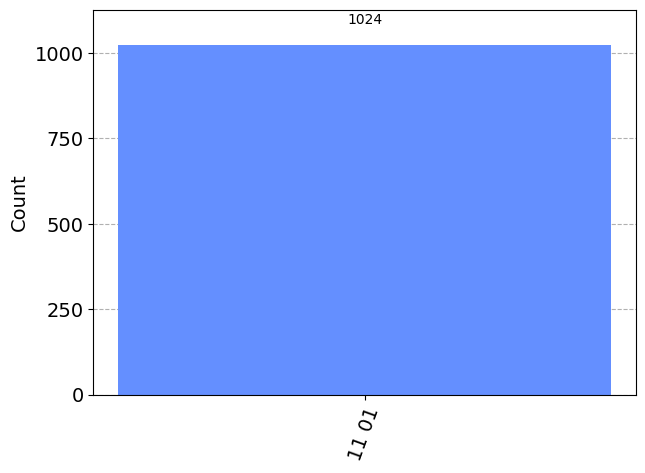

In [8]:
from qiskit import *
from qiskit.visualization import plot_histogram

Key=QuantumRegister(8,'k')
IV=QuantumRegister(8,'iv')
IV1=QuantumRegister(8,'iv1')
Z=QuantumRegister(1,'z')
KS=QuantumRegister(2,'ks')
KS1=QuantumRegister(4,'ks1')
eta=QuantumRegister(2,'eta')
#Out=QuantumRegister(1,'out')
#C=ClassicalRegister(24,'c')
C1=ClassicalRegister(2,'c1')
C2=ClassicalRegister(2,'c2')

Grain=QuantumCircuit(Key,IV,IV1,Z,KS,KS1,eta,C2,C1)




def KSA(IV,rnd):
    for t in range(rnd):
        Grain.reset(Z)

        #z=x2+x4+x7+y5+x4y2+x7y6
        Grain.ccx(Key[4],IV[2],Z)
        Grain.ccx(Key[7],IV[6],Z)
        for i in {2,4,7}:
               Grain.cx(Key[i],Z)
        Grain.cx(IV[5],Z)

        #g=x0+x2+x3+x3x5+x1x2+x4x6
        for i in {2,3}:
            Grain.cx(Key[i],Key[0])
        l=[3,1,4]
        m=[5,2,6]
        for i in range(3):
            Grain.ccx(Key[l[i]],Key[m[i]],Key[0])

        #x8=z+g+y0
        Grain.cx(Z,Key[0])
        Grain.cx(IV[0],Key[0])

        #f=y0+y1+y6+y7
        for i in {1,6,7}:
            Grain.cx(IV[i], IV[0])

        #y8=z+f
        Grain.cx(Z,IV[0])

        for i in range(7):
            Grain.swap(IV[i],IV[i+1])
            Grain.swap(Key[i],Key[i+1])
       
def PRGA(IV,length,KS):
    for j in range(length):
        Grain.reset(Z)
        Grain.ccx(Key[4],IV[2],Z)
        Grain.ccx(Key[7],IV[6],Z)
        for i in {2,4,7}:
               Grain.cx(Key[i],Z)
        Grain.cx(IV[5],Z)

        Grain.cx(Z,KS[j])

        for i in {2,3}:
            Grain.cx(Key[i],Key[0])
        l=[3,1,4]
        m=[5,2,6]
        for i in range(3):
            Grain.ccx(Key[l[i]],Key[m[i]],Key[0])
        Grain.cx(IV[0],Key[0])

        for i in {1,6,7}:
            Grain.cx(IV[i], IV[0])

        for i in range(7):
            Grain.swap(IV[i],IV[i+1])
            Grain.swap(Key[i],Key[i+1])
           
def PRGA_Inverse(IV,length,KS):
    for t in range(length):

        #beta=y0+y5+y6+y7
        Grain.cx(IV[0],IV[7])
        Grain.cx(IV[5],IV[7])
        Grain.cx(IV[6],IV[7])

        #alpha=beta+x1+x2+x2x4+x0x1+x3x5
        Grain.cx(IV[7],Key[7])
        Grain.cx(Key[1],Key[7])
        Grain.cx(Key[2],Key[7])
        Grain.ccx(Key[2],Key[4],Key[7])
        Grain.ccx(Key[0],Key[1],Key[7])
        Grain.ccx(Key[3],Key[5],Key[7])

        for i in range(7):
            Grain.swap(IV[7-i],IV[6-i])
            Grain.swap(Key[7-i],Key[6-i])


def KSA_Inverse(IV,rnd):
    for t in range(rnd):
        #z=x1+x3+x6+y4+x3y1+x6y5
        Grain.reset(Z)
        for i in {1,3,6}:
            Grain.cx(Key[i],Z)    
        Grain.cx(IV[4],Z)
        Grain.ccx(Key[3],IV[1],Z)
        Grain.ccx(Key[6],IV[5],Z)

        #beta=z+y0+y5+y6+y7
        Grain.cx(IV[0],IV[7])
        Grain.cx(IV[5],IV[7])
        Grain.cx(IV[6],IV[7])
        Grain.cx(Z,IV[7])

        #alpha=z+beta+x1+x2+x2x4+x0x1+x3x5
        Grain.cx(IV[7],Key[7])
        Grain.cx(Key[1],Key[7])
        Grain.cx(Key[2],Key[7])
        Grain.cx(Z,Key[7])
        Grain.ccx(Key[2],Key[4],Key[7])
        Grain.ccx(Key[0],Key[1],Key[7])
        Grain.ccx(Key[3],Key[5],Key[7])

        for i in range(7):
            Grain.swap(IV[7-i],IV[6-i])
            Grain.swap(Key[7-i],Key[6-i])





def BlackBox1():
    KSA(IV,16)
    PRGA(IV,2,KS)

def BlackBox1_Inv():
    PRGA_Inverse(IV,2,KS)
    KSA_Inverse(IV,16)
   
def BlackBox2():
    KSA_Inverse(IV,2)
    KSA(IV1,16)
    PRGA(IV1,4,KS1)

   
def BlackBox2_Inv():
    PRGA_Inverse(IV1,4,KS1)
    KSA_Inverse(IV1,16)
    KSA(IV,2)
   
#-----------------------------------Secret Key------------------------------------------    
   
for i in range(8):    
    Grain.reset(Key[i])
#Key=00010110
for i in {1,2,4}:
    Grain.x(Key[i])


#------------------------------------Grain Oracle----------------------------------------

def grain_oracle():
    BlackBox1()
    BlackBox1_Inv()
    BlackBox2()
    BlackBox2_Inv()

    #XOR output of BlackBox1 with last two bits of BlackBox2
    for i in range(2):
        Grain.cx(KS[i],KS1[i+2])
    for i in range(2):
        Grain.x(KS1[i+2])

   
#--------------------------------------Inputs-------------------------------------------

   
#IV=10100011
for i in {0,1,5,7}:
    Grain.x(IV[i])  
# for i in {1,3}:
#     Grain.h(IV[i])

#IV1=10001101
for i in {0,2,3,7}:
    Grain.x(IV1[i])
# for i in {0,1,3,5}:
#     Grain.h(IV1[i])


   
#---------------------------------------------Attack------------------------------------      
   
def state_preparation():
    Grain.h([eta[0],eta[1]])
    Grain.cx(IV1[0],eta[0])
    Grain.cx(IV1[1],eta[1])
    Grain.x([eta[0],eta[1]])
def grover_oracle():
        Grain.cz(eta[0],eta[1])
        Grain.h([eta[0],eta[1]])
        Grain.z([eta[0],eta[1]])
        Grain.cz(eta[0],eta[1])
        Grain.h([eta[0],eta[1]])
def un_computation():
    Grain.x([eta[0],eta[1]])
    Grain.cx(IV1[1],eta[1])
    Grain.cx(IV1[0],eta[0])

state_preparation()
grain_oracle()


grover_oracle()
un_computation()


Grain.measure(KS1[2],C1[0])
Grain.measure(KS1[3],C1[1])

Grain.measure(eta[0],C2[0])
Grain.measure(eta[1],C2[1])

# for i in range(8):
#     Grain.measure(Key[i],C[i])
# for i in range(8):
#     Grain.measure(IV[i],C[i+8])
# for i in range(8):
#     Grain.measure(IV1[i],C[i+16])
   

simulator = Aer.get_backend('qasm_simulator')
job = execute(Grain, simulator, shots=1024)
result = job.result()
counts = result.get_counts(Grain)
plot_histogram(counts)
#print(counts)

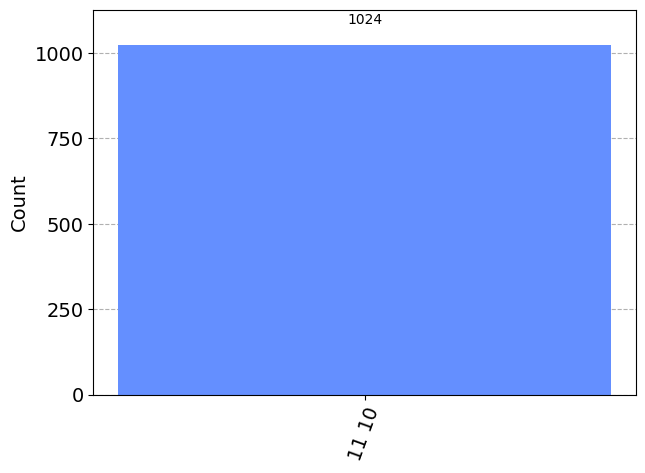

In [9]:
from qiskit import *
from qiskit.visualization import plot_histogram

Key=QuantumRegister(8,'k')
IV=QuantumRegister(8,'iv')
IV1=QuantumRegister(8,'iv1')
Z=QuantumRegister(1,'z')
KS=QuantumRegister(2,'ks')
KS1=QuantumRegister(4,'ks1')
eta=QuantumRegister(2,'eta')
#Out=QuantumRegister(1,'out')
#C=ClassicalRegister(24,'c')
C1=ClassicalRegister(2,'c1')
C2=ClassicalRegister(2,'c2')

Grain=QuantumCircuit(Key,IV,IV1,Z,KS,KS1,eta,C2,C1)




def KSA(IV,rnd):
    for t in range(rnd):
        Grain.reset(Z)

        #z=x2+x4+x7+y5+x4y2+x7y6
        Grain.ccx(Key[4],IV[2],Z)
        Grain.ccx(Key[7],IV[6],Z)
        for i in {2,4,7}:
               Grain.cx(Key[i],Z)
        Grain.cx(IV[5],Z)

        #g=x0+x2+x3+x3x5+x1x2+x4x6
        for i in {2,3}:
            Grain.cx(Key[i],Key[0])
        l=[3,1,4]
        m=[5,2,6]
        for i in range(3):
            Grain.ccx(Key[l[i]],Key[m[i]],Key[0])

        #x8=z+g+y0
        Grain.cx(Z,Key[0])
        Grain.cx(IV[0],Key[0])

        #f=y0+y1+y6+y7
        for i in {1,6,7}:
            Grain.cx(IV[i], IV[0])

        #y8=z+f
        Grain.cx(Z,IV[0])

        for i in range(7):
            Grain.swap(IV[i],IV[i+1])
            Grain.swap(Key[i],Key[i+1])
       
def PRGA(IV,length,KS):
    for j in range(length):
        Grain.reset(Z)
        Grain.ccx(Key[4],IV[2],Z)
        Grain.ccx(Key[7],IV[6],Z)
        for i in {2,4,7}:
               Grain.cx(Key[i],Z)
        Grain.cx(IV[5],Z)

        Grain.cx(Z,KS[j])

        for i in {2,3}:
            Grain.cx(Key[i],Key[0])
        l=[3,1,4]
        m=[5,2,6]
        for i in range(3):
            Grain.ccx(Key[l[i]],Key[m[i]],Key[0])
        Grain.cx(IV[0],Key[0])

        for i in {1,6,7}:
            Grain.cx(IV[i], IV[0])

        for i in range(7):
            Grain.swap(IV[i],IV[i+1])
            Grain.swap(Key[i],Key[i+1])
           
def PRGA_Inverse(IV,length,KS):
    for t in range(length):

        #beta=y0+y5+y6+y7
        Grain.cx(IV[0],IV[7])
        Grain.cx(IV[5],IV[7])
        Grain.cx(IV[6],IV[7])

        #alpha=beta+x1+x2+x2x4+x0x1+x3x5
        Grain.cx(IV[7],Key[7])
        Grain.cx(Key[1],Key[7])
        Grain.cx(Key[2],Key[7])
        Grain.ccx(Key[2],Key[4],Key[7])
        Grain.ccx(Key[0],Key[1],Key[7])
        Grain.ccx(Key[3],Key[5],Key[7])

        for i in range(7):
            Grain.swap(IV[7-i],IV[6-i])
            Grain.swap(Key[7-i],Key[6-i])


def KSA_Inverse(IV,rnd):
    for t in range(rnd):
        #z=x1+x3+x6+y4+x3y1+x6y5
        Grain.reset(Z)
        for i in {1,3,6}:
            Grain.cx(Key[i],Z)    
        Grain.cx(IV[4],Z)
        Grain.ccx(Key[3],IV[1],Z)
        Grain.ccx(Key[6],IV[5],Z)

        #beta=z+y0+y5+y6+y7
        Grain.cx(IV[0],IV[7])
        Grain.cx(IV[5],IV[7])
        Grain.cx(IV[6],IV[7])
        Grain.cx(Z,IV[7])

        #alpha=z+beta+x1+x2+x2x4+x0x1+x3x5
        Grain.cx(IV[7],Key[7])
        Grain.cx(Key[1],Key[7])
        Grain.cx(Key[2],Key[7])
        Grain.cx(Z,Key[7])
        Grain.ccx(Key[2],Key[4],Key[7])
        Grain.ccx(Key[0],Key[1],Key[7])
        Grain.ccx(Key[3],Key[5],Key[7])

        for i in range(7):
            Grain.swap(IV[7-i],IV[6-i])
            Grain.swap(Key[7-i],Key[6-i])





def BlackBox1():
    KSA(IV,16)
    PRGA(IV,2,KS)

def BlackBox1_Inv():
    PRGA_Inverse(IV,2,KS)
    KSA_Inverse(IV,16)
   
def BlackBox2():
    KSA_Inverse(IV,2)
    KSA(IV1,16)
    PRGA(IV1,4,KS1)

   
def BlackBox2_Inv():
    PRGA_Inverse(IV1,4,KS1)
    KSA_Inverse(IV1,16)
    KSA(IV,2)
   
#-----------------------------------Secret Key------------------------------------------    
   
for i in range(8):    
    Grain.reset(Key[i])
#Key=11110001
for i in {0,4,5,6,7}:
    Grain.x(Key[i])


#------------------------------------Grain Oracle----------------------------------------

def grain_oracle():
    BlackBox1()
    BlackBox1_Inv()
    BlackBox2()
    BlackBox2_Inv()

    #XOR output of BlackBox1 with last two bits of BlackBox2
    for i in range(2):
        Grain.cx(KS[i],KS1[i+2])
    for i in range(2):
        Grain.x(KS1[i+2])

   
#--------------------------------------Inputs-------------------------------------------

   
#IV=10100001
for i in {0,5,7}:
    Grain.x(IV[i])  

#IV1=10000110
for i in {1,2,7}:
    Grain.x(IV1[i])


   
#---------------------------------------------Attack------------------------------------      
   
def state_preparation():
    Grain.h([eta[0],eta[1]])
    Grain.cx(IV1[0],eta[0])
    Grain.cx(IV1[1],eta[1])
    Grain.x([eta[0],eta[1]])
def grover_oracle():
        Grain.cz(eta[0],eta[1])
        Grain.h([eta[0],eta[1]])
        Grain.z([eta[0],eta[1]])
        Grain.cz(eta[0],eta[1])
        Grain.h([eta[0],eta[1]])
def un_computation():
    Grain.x([eta[0],eta[1]])
    Grain.cx(IV1[1],eta[1])
    Grain.cx(IV1[0],eta[0])

state_preparation()
grain_oracle()


grover_oracle()
un_computation()


Grain.measure(KS1[2],C1[0])
Grain.measure(KS1[3],C1[1])

Grain.measure(eta[0],C2[0])
Grain.measure(eta[1],C2[1])

# for i in range(8):
#     Grain.measure(Key[i],C[i])
# for i in range(8):
#     Grain.measure(IV[i],C[i+8])
# for i in range(8):
#     Grain.measure(IV1[i],C[i+16])
   

simulator = Aer.get_backend('qasm_simulator')
job = execute(Grain, simulator, shots=1024)
result = job.result()
counts = result.get_counts(Grain)
plot_histogram(counts)
#print(counts)